In [10]:
import random
def process_bed_files(file1, file2):
    # Открываем файлы и читаем строки
    with open(file1, 'r') as f1, open(file2, 'r') as f2:
        lines1 = f1.readlines()
        lines2 = f2.readlines()

    # Создаем два пустых списка
    list1 = []
    list2 = []

    # Функция для обработки строк и заполнения списка
    def process_lines(lines, result_list):
        for line in lines:
            if line.startswith("chr"):
                parts = line.split()
                if len(parts) >= 3:
                    # Получаем chr3 и два числа
                    chr_part = parts[0]
                    try:
                        num1 = int(parts[1])
                        num2 = int(parts[2])
                        result_list.append((num1, num2))
                    except ValueError:
                        continue  # Пропускаем строки с некорректными числами

    # Обрабатываем оба файла
    process_lines(lines1, list1)
    process_lines(lines2, list2)

    return list1, list2

# Пример использования
file1 = "randomD.00001.bed"
file2 = "randomG.00001.bed"
Domens, Genes = process_bed_files(file1, file2)
expressions = [random.randint(0, 55) for _ in range(len(Genes))]

# Выводим результат
print("expressions:", expressions[:10])
# Выводим результат
print("Domens:", Domens[:10])
print("Genes:", Genes[:10])


expressions: [49, 40, 36, 13, 17, 0, 51, 19, 35, 24]
Domens: [(369, 122316), (122432, 250032), (250764, 385001), (385610, 494319), (494729, 620371), (621061, 756493), (756904, 863709), (864458, 962240), (962417, 1099542), (1099757, 1222988)]
Genes: [(98466, 208131), (224652, 265631), (302647, 312044), (420097, 455922), (597304, 746008), (990405, 1066907), (1121584, 1125949), (1183083, 1260046), (1481269, 1498746), (1705790, 1748329)]


In [18]:
import numpy as np

gene_lengths = [end - start for start, end in Genes]

# Считаем среднюю длину
mean_gene_len = sum(gene_lengths) / len(gene_lengths) if gene_lengths else 0



def map_genes_to_domains(Domens, Genes, expressions):
    # Создаем пустой массив для доменов
    arr_of_domens = np.empty(len(Domens), dtype=object)

    # Указатель на текущий ген
    gene_index = 0

    # Проходим по каждому домену
    for domain_index, (dom_start, dom_end) in enumerate(Domens):
        this_domen = []

        # Сдвигаем указатель генов, пока ген полностью "до" домена
        while gene_index < len(Genes) and Genes[gene_index][1] < dom_start:
            gene_index += 1

        # Обрабатываем гены, которые пересекаются с доменом
        temp_index = gene_index  # Сохраняем текущую позицию указателя
        while temp_index < len(Genes) and Genes[temp_index][0] < dom_end:
            gene_start, gene_end = Genes[temp_index]
            gene_length = gene_end - gene_start
            expression = expressions[temp_index]

            # Полное вхождение гена в домен
            if dom_start <= gene_start and gene_end <= dom_end:
                this_domen.append(expression)

            # Полное покрытие домена геном
            elif gene_start <= dom_start and dom_end <= gene_end:
                overlap_length = dom_end - dom_start
                this_domen.append(expression * (overlap_length / gene_length))

            # Ген перекрывает левую границу домена
            elif gene_start < dom_start < gene_end <= dom_end:
                overlap_length = gene_end - dom_start
                this_domen.append(expression * (overlap_length / gene_length))

            # Ген перекрывает правую границу домена
            elif dom_start <= gene_start < dom_end < gene_end:
                overlap_length = dom_end - gene_start
                this_domen.append(expression * (overlap_length / gene_length))

            # Переход к следующему гену
            temp_index += 1

        arr_of_domens[domain_index] = np.array(this_domen)

    return arr_of_domens


In [21]:
def count_statvalues(arr_of_domens: np.ndarray) -> tuple:
    means = []
    variances = []

    for domen in arr_of_domens:
        if domen is not None and len(domen) > 0:
            means.append(np.mean(domen))
            variances.append(np.var(domen))
    
    overall_mean = np.mean(means) if means else None
    overall_dispersion = np.mean(variances) if variances else None

    return overall_mean, overall_dispersion

def z_criterium(mu1: float, mu2: float, sig1: float, sig2: float, n: int) -> float:
    return (mu1 - mu2) / np.sqrt(sig1/n + sig2/n)

def rotate_genes(Domens, Genes, expressions, shift_value):
    # Находим общую длину хромосомы (конец последнего гена)
    chrom_length = max(gene[1] for gene in Genes)

    # Сдвигаем координаты всех генов
    new_genes = []
    for start, end in Genes:
        new_start = (start + shift_value) % chrom_length
        new_end = (end + shift_value) % chrom_length
        new_genes.append((new_start, new_end))

    # Массив expressions должен быть также сдвинут
    new_expressions = expressions[-shift_value % len(expressions):] + expressions[:-shift_value % len(expressions)]

    # Вызываем функцию маппинга с новыми сдвинутыми данными
    arr_of_domens = map_genes_to_domains(Domens, new_genes, new_expressions)

    return arr_of_domens

In [24]:
def one_chromosome_rework(arr_of_domens) -> float:

    mu1, d1 = count_statvalues(arr_of_domens)
    mu_list, d_list = [], []
    
    for _ in range(10000): # ЭТО НАДО БУДЕТ ПОМЕНЯТЬ!!!!!!!
        shift_value = int(np.random.rand() * mean_gene_len)
        new_arr_of_domens = rotate_genes(Domens, Genes, expressions, shift_value)
        mu2, d2 = count_statvalues(new_arr_of_domens)
        if mu2 is not None:
            mu_list.append(mu2)
        if d2 is not None:
            d_list.append(d2)

    mu2 = np.mean(mu_list)
    d2 = np.mean(d_list)
    return z_criterium(mu1, mu2, d1, d2, len(Genes))

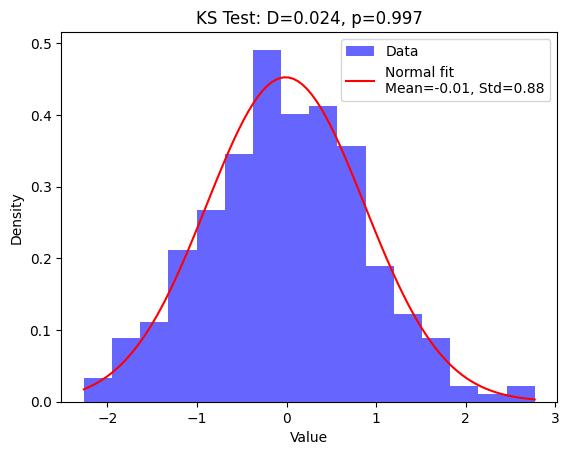

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest

# Чтение данных из stats.txt
with open('stats.txt', 'r') as file:
    data = [float(line.strip()) for line in file]

data = [a + 1 for a in data]
# Количество столбцов в гистограмме (корень из количества чисел)
bins = int(np.sqrt(len(data)))

# Построение гистограммы
plt.hist(data, bins=bins, density=True, alpha=0.6, color='blue', label='Data')

# Фитируем нормальное распределение
mean, std = norm.fit(data)
x = np.linspace(min(data), max(data), 100)
pdf = norm.pdf(x, mean, std)

# График нормального распределения
plt.plot(x, pdf, 'r-', label=f'Normal fit\nMean={mean:.2f}, Std={std:.2f}')
plt.legend()

# Проверка на нормальность (тест Колмогорова-Смирнова)
ks_stat, p_value = kstest(data, 'norm', args=(mean, std))
plt.title(f'KS Test: D={ks_stat:.3f}, p={p_value:.3f}')

# Сохранение и показ графика
plt.xlabel('Value')
plt.ylabel('Density')
plt.savefig('histogram.png')
plt.show()


In [5]:
import time
import numpy as np
test = np.linspace(1, 100, 99)
start = time.time()
mu = np.mean(test)
print((start-float(time.time()))*10e11)

-1.7367798959629756e+21


In [2]:
import numpy as np
import matplotlib.pyplot as plt
res = []
for _ in range(1000):
    shift_value = int(np.random.rand() * mean_gene_len)
    shift_value = shift_value*np.random.choice([-1, 1])
    res.append(shift_value)
plt.hist(res)
plt.show()

NameError: name 'mean_gene_len' is not defined